<a href="https://colab.research.google.com/github/koulkoudakis/dog-breed-classifier/blob/main/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classifier

**Name:** Dog Breed Classifier

**Author:** Sharome Burton

**Date:** 07/20/2021

**Description:** Machine learning model used to determine the breed of a dog from a given image.

**Kaggle:** https://www.kaggle.com/sharomeethan/disaster-tweet-classifier

## 1. Problem definition
> How well can we identify the breed of a dog from a given image?

## 2. Data
We are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique `id`. The dataset comprises 120 breeds of dogs.
   
* `train.zip` - the training set, we are provided the breed for these dogs
* `test.zip` - the test set, we must predict the probability of each breed for each image
* `sample_submission.csv` - a sample submission file in the correct format
* `labels.csv` - the breeds for the images in the train set

There are 10,000+ labeled images in each set.
    
source: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Features

   * `id` - a unique identifier for each image
   * `breed` - the breed of the dog, eg. 
    * affenpinscher
    * afghan_hound
    * african_hunting_dog
    * airedale
    * american_staffordshire_terrier 
   
## 4. Evaluation 

> **Goal:** Determine the breed of a dog in a given image with >75% accuracy.

The evaluation is a file with prediction probabilities for each dog breed of each test image. Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

source: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation



## Loading Dataset

In [ ]:
# Unzipping dataset
# !unzip "drive/MyDrive/ML Projects/dog-breed-identification.zip" -d "drive/MyDrive/ML Projects/"

## Getting tools ready

* Import TensorFlow 2.x 
* Import TensorFlow Hub
* Ensure access to GPU


In [ ]:
# TensorFlow
import tensorflow as tf
print("Tf version:", tf.__version__)
# Tensorflow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)


# Check GPU availability
print("GPU: ", "available" if tf.config.list_physical_devices else "not available")

Tf version: 2.5.0
TF Hub version: 0.12.0
GPU:  available


## Getting data ready
With all machine learning models, data has to be in numerical format. Here we must convert our images into tensors.


In [ ]:
# Display labels
import pandas as pd

labels_csv = pd.read_csv("/content/drive/MyDrive/ML Projects/labels.csv")


print(labels_csv.describe())
labels_csv.describe()
labels_csv


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     16cc38641158115b57a4610e40e5f6a9  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [ ]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

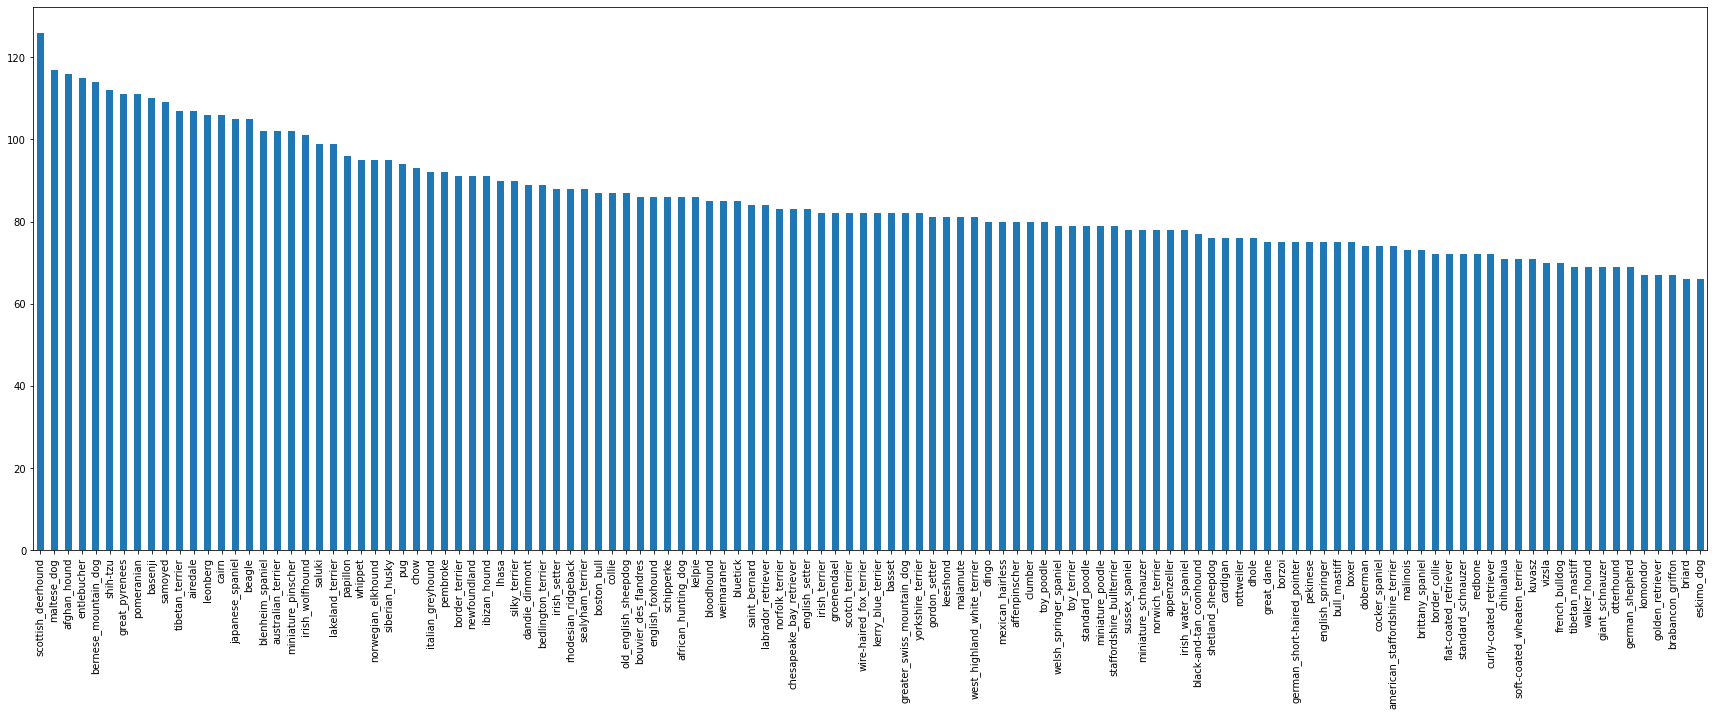

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(30,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

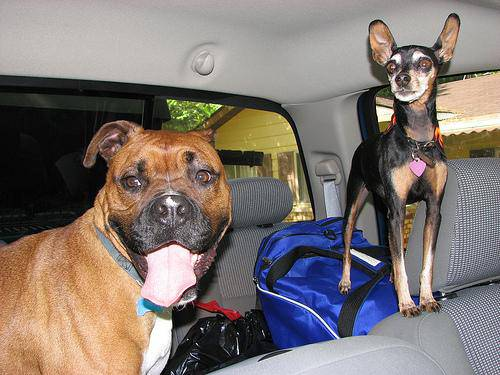

In [ ]:
# View image sample
from IPython.display import Image
Image("/content/drive/MyDrive/ML Projects/train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg")

### Fetching images and labels



In [ ]:
labels_csv.tail()

,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/ML Projects/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check first 10
filenames[:10]

['drive/MyDrive/ML Projects/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/ML Projects/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/ML Projects/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/ML Projects/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/ML Projects/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/ML Projects/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/ML Projects/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/ML Projects/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/ML Projects/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/ML Projects/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of images
import os
if len(os.listdir("drive/MyDrive/ML Projects/train/")) != len(filenames):
  print("Mismatched number of filenames and files, check target directory.")
else:
  print("Identical number of filenames and files.")

Identical number of filenames and files.


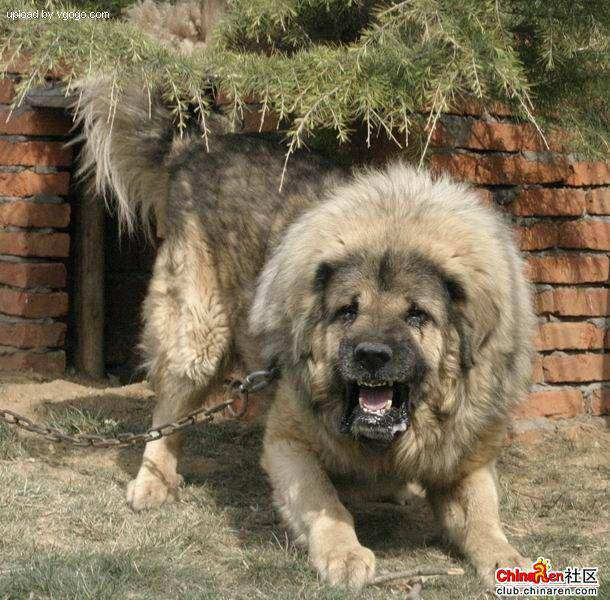

In [ ]:
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'